# Что это такое?

Мы с вами предобучили `resnet50d` из `timm` с помощью SSL метода `SimSiam`. Давайте теперь воспользуемся этим предобученным
чекпоинтом по прямому назначению - в качестве стартовых весов для последующей задачи классификации типов одежды. Быстренько
накидаем простой классификационный моделлинг и проучим модель по следующему сценарию:

- Обучим `resnet50d` со случайной инциализацией;
- Обучим `resnet50d`, стартуя с SSL-весов;
- Обучим `resnet50d`, стартуя с ImageNet-весов из `timm`.

Нам интересно сравнить итоговую точность (для простоты возьмем обычную `accuracy`, хотя это не лучший вариант в этой задаче 
из-за дисбаланса).

### Конфигурационный файлик курильщика

In [2]:
import albumentations as album
from albumentations.pytorch.transforms import ToTensorV2


class CFG:
    image_folder: str = "../dataset/clothing-dataset/images"
    csv_path: str = "../dataset/clothing-dataset/images.csv"
    ssl_checkpoint_path: str | None = "../checkpoints/uv8r77gx/best_checkpoint_resnet50d.pth"

    num_classes: int = 20
    timm_pretrained: bool = False
    backbone_name: str = "resnet50d"

    lr: float = 0.0003
    device: str = "cuda:0"
    num_workers: int = 6
    cache_images: bool = True
    batch_size: int = 96
    epochs: int = 5
    train_transforms: album.Compose = album.Compose(
        [album.RandomResizedCrop(224, 224), album.HorizontalFlip(), album.Normalize(), ToTensorV2()],
    )
    test_transforms: album.Compose = album.Compose([album.Resize(224, 224), album.Normalize(), ToTensorV2()])


cfg: CFG = CFG()

### Рисовалка

In [17]:
from matplotlib import pyplot as plt

%matplotlib inline


def plot_history(cfg: CFG, history: dict[str, list[float]]) -> None:
    plt.figure(figsize=(12, 10))
    plt.plot(range(cfg.epochs), history["train_loss"], label="Training loss")
    plt.plot(range(cfg.epochs), history["validation_loss"], label="Validation loss")
    plt.plot(range(cfg.epochs), history["validation_acc"], label="Validation Acc@1")
    plt.legend()
    plt.xticks(range(cfg.epochs), map(str, range(1, cfg.epochs + 1)))
    max_acc = max(history["validation_acc"])
    title = "Результаты обучения"
    if cfg.ssl_checkpoint_path is None:
        suffix = " с ImageNet инициализацией" if cfg.timm_pretrained else " со случайной инициализацией"  # noqa: RUF001
        title = title + suffix
    else:
        title = title + " с SSL-предобучением"  # noqa: RUF001
    title = title + f". Максимальная accuracy = {max_acc:.3f}"
    plt.title(title)
    plt.show()

### Датасет

- Датасет на основе `CSV`-файла с кэшированием картинок;
- Функция, строящая даталодаеры.

In [5]:
import pathlib
import typing as ty

import albumentations as album
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset

from source.datasets.utils import fix_worker_seeds, read_image


class CSVDataset(Dataset):
    __label_mapper: ty.ClassVar[dict[str, int]] = {
        "Blazer": 0,
        "Blouse": 1,
        "Body": 2,
        "Dress": 3,
        "Hat": 4,
        "Hoodie": 5,
        "Longsleeve": 6,
        "Not sure": 7,
        "Other": 8,
        "Outwear": 9,
        "Pants": 10,
        "Polo": 11,
        "Shirt": 12,
        "Shoes": 13,
        "Shorts": 14,
        "Skip": 15,
        "Skirt": 16,
        "T-Shirt": 17,
        "Top": 18,
        "Undershirt": 19
    }
    def __init__(
        self, image_dir: str, dataframe: pd.DataFrame, transforms: album.Compose, cached: bool = False
    ) -> None:
        self.__labels = dataframe["label"].map(self.__label_mapper).to_numpy()
        self.__image_collection = (
            dataframe["image"]
            .apply(lambda image_hash: pathlib.Path(image_dir).joinpath(image_hash).as_posix() + ".jpg")
            .to_numpy()
        )
        self.transforms = transforms
        self.__cached = cached
        if self.__cached:
            self.__image_collection = list(map(read_image, self.__image_collection))

    def __len__(self) -> int:
        return len(self.__image_collection)

    def __getitem__(self, index: int) -> dict[str, torch.Tensor | int]:
        image = self.__image_collection[index]
        if not self.__cached:
            image_path = self.__image_collection[index]
            image = read_image(image_path)
        label = self.__labels[index].item()
        data_point = {"image": image, "label": label}
        if self.transforms is not None:
            data_point["image"] = self.transforms(image=image)["image"]
        return data_point


def build_dataloaders(cfg: CFG, dataframe: pd.DataFrame) -> dict[str, DataLoader[CSVDataset]]:
    split = {
        "train": dataframe.query("fold in [0, 1, 2]").reset_index(drop=True),
        "val": dataframe.query("fold in [3]").reset_index(drop=True),
        "test": dataframe.query("fold in [4]").reset_index(drop=True),
    }
    transforms = {"train": cfg.train_transforms, "val": cfg.test_transforms, "test": cfg.test_transforms}
    dataloaders = {}
    for subset_name in split:
        dataloaders[subset_name] = DataLoader(
            CSVDataset(cfg.image_folder, split[subset_name], transforms[subset_name], cached=cfg.cache_images),
            cfg.batch_size,
            shuffle=subset_name == "train",
            pin_memory=torch.cuda.is_available(),
            num_workers=cfg.num_workers,
            worker_init_fn=fix_worker_seeds,
        )
    return dataloaders

### Функции для обучалки

- Создание классификационной модели;
- Обучение на одной эпохе;
- Валидация на одной эпохе;
- Общая обучалка.

In [6]:
from collections import defaultdict

import timm


def build_classification_model(config: CFG, device: torch.device) -> torch.nn.Module:
    model = timm.create_model(config.backbone_name, num_classes=config.num_classes, pretrained=config.timm_pretrained)
    if config.ssl_checkpoint_path is not None:
        # strict = False, так как в нашем бекбоне нет исходной классификационной головы.
        model.load_state_dict(torch.load(config.ssl_checkpoint_path), strict=False)
    return model.to(device)


def train_one_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    loader: DataLoader,
    criterion: torch.nn.CrossEntropyLoss,
    device: torch.device
) -> float:
    model.train()
    training_loss = torch.as_tensor(0.0, device=device)
    for batch in loader:
        images = batch["image"].to(device, non_blocking=True)
        labels = batch["label"].to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss
    return training_loss.detach().cpu().item() / len(loader)


@torch.no_grad()
def validate_one_epoch(
    model: torch.nn.Module,
    loader: DataLoader,
    criterion: torch.nn.CrossEntropyLoss,
    device: torch.device
) -> tuple[float, float]:
    model.eval()
    validation_loss = torch.as_tensor(0.0, device=device)
    validation_acc = torch.as_tensor(0.0, device=device)
    for batch in loader:
        images = batch["image"].to(device, non_blocking=True)
        labels = batch["label"].to(device, non_blocking=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        validation_loss += loss
        validation_acc += (outputs.argmax(dim=1) == labels).float().mean()
    validation_loss = validation_loss.detach().cpu().item() / len(loader)
    validation_acc = validation_acc.detach().cpu().item() / len(loader)
    return validation_loss, validation_acc


def train(cfg: CFG) -> defaultdict[str, list[float]]:
    device = torch.device(cfg.device)
    model = build_classification_model(cfg, device=device)
    dataframe = pd.read_csv(cfg.csv_path)
    dataloaders = build_dataloaders(cfg, dataframe)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)
    history = defaultdict(list)
    for epoch in range(cfg.epochs):
        training_loss = train_one_epoch(model, optimizer, dataloaders["train"], criterion, device)
        validation_loss, validation_acc = validate_one_epoch(model, dataloaders["val"], criterion, device)
        scheduler.step()
        print(  # noqa: T201
            f"[EPOCH {epoch + 1}/{cfg.epochs}] TL={training_loss:.5f}, VL={validation_loss:.5f}, VA={validation_acc:.3f}"
        )
        history["train_loss"].append(training_loss)
        history["validation_loss"].append(validation_loss)
        history["validation_acc"].append(validation_acc)
    return history

### Обучение

#### Случайная инициализация

[EPOCH 1/50] TL=2.54510, VL=2.65470, VA=0.179
[EPOCH 2/50] TL=2.36319, VL=2.58345, VA=0.200
[EPOCH 3/50] TL=2.28982, VL=2.52246, VA=0.212
[EPOCH 4/50] TL=2.19278, VL=2.71457, VA=0.208
[EPOCH 5/50] TL=2.17062, VL=2.63307, VA=0.220
[EPOCH 6/50] TL=2.09179, VL=2.57002, VA=0.204
[EPOCH 7/50] TL=2.04240, VL=2.52319, VA=0.234
[EPOCH 8/50] TL=1.99776, VL=2.60369, VA=0.207
[EPOCH 9/50] TL=1.93810, VL=2.49457, VA=0.264
[EPOCH 10/50] TL=1.90181, VL=2.53838, VA=0.267
[EPOCH 11/50] TL=1.84606, VL=2.55352, VA=0.262
[EPOCH 12/50] TL=1.82258, VL=2.39414, VA=0.297
[EPOCH 13/50] TL=1.75791, VL=2.53165, VA=0.267
[EPOCH 14/50] TL=1.70366, VL=2.48756, VA=0.268
[EPOCH 15/50] TL=1.68479, VL=2.37168, VA=0.324
[EPOCH 16/50] TL=1.61380, VL=2.47359, VA=0.273
[EPOCH 17/50] TL=1.57215, VL=2.41859, VA=0.306
[EPOCH 18/50] TL=1.54546, VL=2.47868, VA=0.313
[EPOCH 19/50] TL=1.51132, VL=2.37940, VA=0.302
[EPOCH 20/50] TL=1.46743, VL=2.39806, VA=0.323
[EPOCH 21/50] TL=1.43151, VL=2.41823, VA=0.328
[EPOCH 22/50] TL=1.378

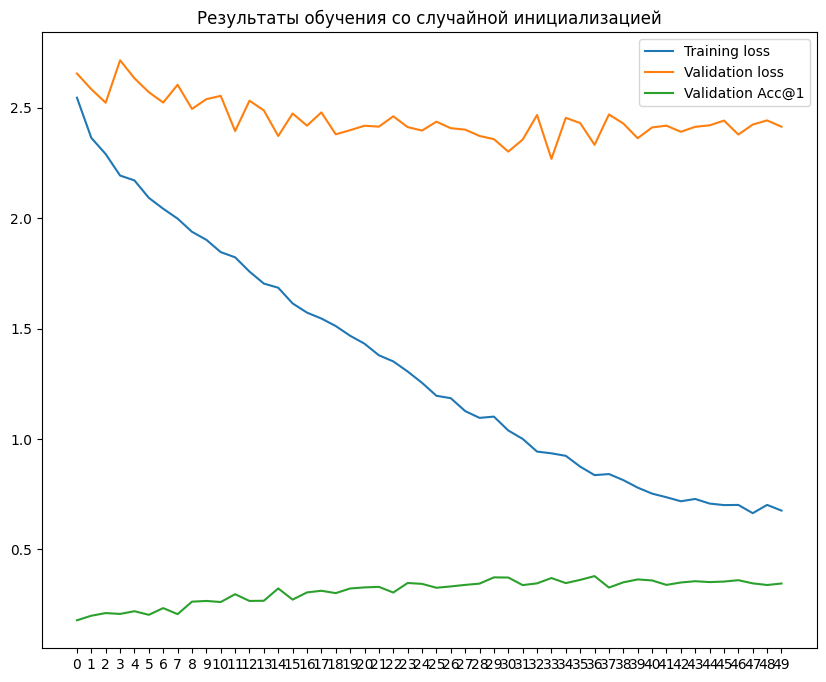

In [8]:
cfg.ssl_checkpoint_path = None
cfg.epochs = 50
random_init_history = train(cfg)
plot_history(cfg, random_init_history)

#### Предобученный SSL-чекпоинт

[EPOCH 1/50] TL=2.63507, VL=2.39143, VA=0.350
[EPOCH 2/50] TL=2.12044, VL=2.35755, VA=0.313
[EPOCH 3/50] TL=1.93802, VL=2.51566, VA=0.330
[EPOCH 4/50] TL=1.85022, VL=2.07884, VA=0.401
[EPOCH 5/50] TL=1.76120, VL=1.97356, VA=0.420
[EPOCH 6/50] TL=1.66869, VL=2.08954, VA=0.400
[EPOCH 7/50] TL=1.60170, VL=1.93292, VA=0.432
[EPOCH 8/50] TL=1.54914, VL=1.92488, VA=0.447
[EPOCH 9/50] TL=1.48108, VL=1.86064, VA=0.461
[EPOCH 10/50] TL=1.40980, VL=2.04414, VA=0.411
[EPOCH 11/50] TL=1.36403, VL=1.70463, VA=0.523
[EPOCH 12/50] TL=1.30531, VL=1.93239, VA=0.410
[EPOCH 13/50] TL=1.23344, VL=1.77707, VA=0.467
[EPOCH 14/50] TL=1.22677, VL=1.62425, VA=0.532
[EPOCH 15/50] TL=1.16874, VL=1.57571, VA=0.534
[EPOCH 16/50] TL=1.16297, VL=1.70372, VA=0.509
[EPOCH 17/50] TL=1.15241, VL=1.59073, VA=0.522
[EPOCH 18/50] TL=1.06713, VL=1.48618, VA=0.550
[EPOCH 19/50] TL=1.03729, VL=1.51491, VA=0.562
[EPOCH 20/50] TL=0.99272, VL=1.62667, VA=0.547
[EPOCH 21/50] TL=0.97342, VL=1.58870, VA=0.526
[EPOCH 22/50] TL=0.927

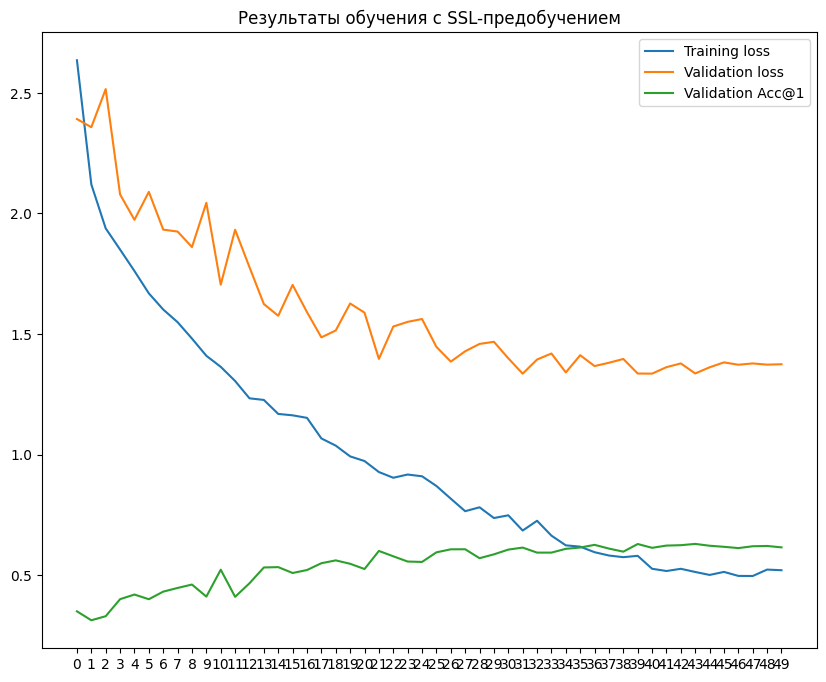

In [9]:
cfg.ssl_checkpoint_path = "../checkpoints/uv8r77gx/best_checkpoint_resnet50d.pth"
ssl_init_history = train(cfg)
plot_history(cfg, ssl_init_history)

#### ImageNet инициализация

[EPOCH 1/50] TL=2.03146, VL=1.21790, VA=0.676
[EPOCH 2/50] TL=1.09289, VL=1.03093, VA=0.717
[EPOCH 3/50] TL=0.81469, VL=0.93968, VA=0.732
[EPOCH 4/50] TL=0.72148, VL=0.81941, VA=0.765
[EPOCH 5/50] TL=0.58447, VL=0.83909, VA=0.766
[EPOCH 6/50] TL=0.52703, VL=0.83380, VA=0.761
[EPOCH 7/50] TL=0.48100, VL=0.83407, VA=0.783
[EPOCH 8/50] TL=0.43484, VL=0.87883, VA=0.772
[EPOCH 9/50] TL=0.36838, VL=0.94617, VA=0.766
[EPOCH 10/50] TL=0.36257, VL=0.97861, VA=0.749
[EPOCH 11/50] TL=0.33358, VL=0.91669, VA=0.782
[EPOCH 12/50] TL=0.33898, VL=0.89037, VA=0.778
[EPOCH 13/50] TL=0.28110, VL=0.97881, VA=0.763
[EPOCH 14/50] TL=0.25174, VL=0.96795, VA=0.755
[EPOCH 15/50] TL=0.26461, VL=0.99596, VA=0.766
[EPOCH 16/50] TL=0.23334, VL=1.02068, VA=0.766
[EPOCH 17/50] TL=0.22125, VL=1.06497, VA=0.754
[EPOCH 18/50] TL=0.21755, VL=1.08082, VA=0.752
[EPOCH 19/50] TL=0.22759, VL=1.13755, VA=0.742
[EPOCH 20/50] TL=0.19922, VL=1.10511, VA=0.761
[EPOCH 21/50] TL=0.20489, VL=1.10446, VA=0.756
[EPOCH 22/50] TL=0.180

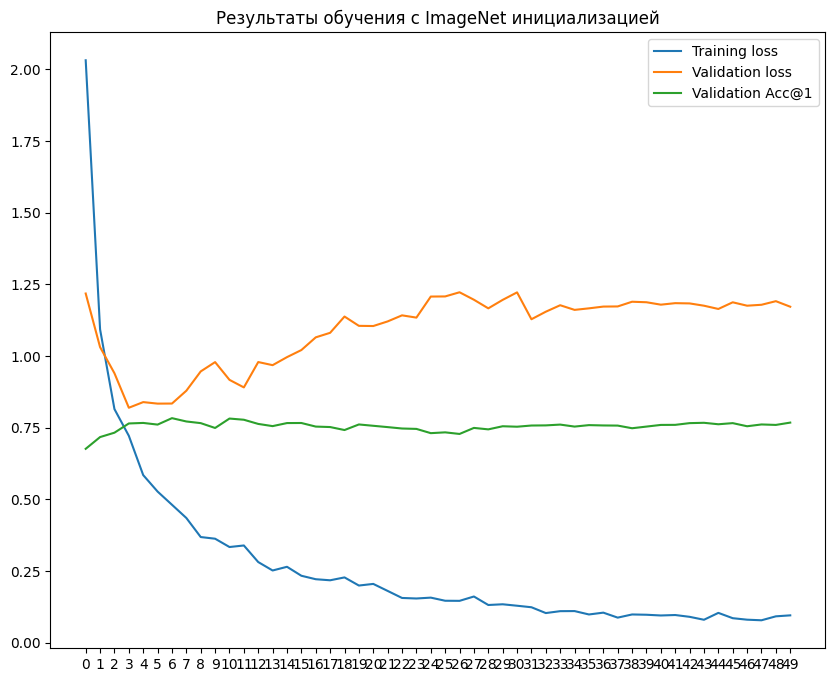

In [10]:
cfg.ssl_checkpoint_path = None
cfg.timm_pretrained = True
imagenet_init_history = train(cfg)
plot_history(cfg, imagenet_init_history)

#### Сравнение `accuracy`

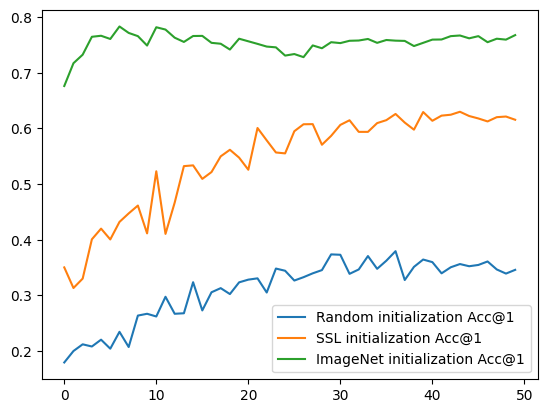

In [11]:
plt.plot(range(cfg.epochs), random_init_history["validation_acc"], label="Random initialization Acc@1")
plt.plot(range(cfg.epochs), ssl_init_history["validation_acc"], label="SSL initialization Acc@1")
plt.plot(range(cfg.epochs), imagenet_init_history["validation_acc"], label="ImageNet initialization Acc@1")
plt.legend()
plt.show()

Сразу видно, что SSL-предобучение дает огромный буст по сравнению со случайной инициализацией. К сожалению, мне не удалось тут побить ImageNet инициализацию, но я полагаю, что при должном выборе параметров обучения это вполне возможно.

Тут важно было увидеть, что из палок и навоза без какой либо разметки в случае невозможности использования ImageNet весов, можно быстро и легко наделать себе SSL-чекпоинтов, которые сильно забустят метрику относительно случайной инициализации.